# 10. Logistic Regression

## 10.5 Bayesian logistic regression

### 10.5.1 Laplace approximation

> Author: Meduri Venkata Shivaditya

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Creating data
N = 30
D = 2

N_zeros = np.zeros(N)
N_ones = np.ones(N)

mu1 = np.stack((N_ones, 5 * N_ones), axis=1)  # mu1 = (1, 5) of shape (N, D)
mu2 = np.stack((-5 * N_ones, N_ones), axis=1) # mu2 = (-5, 1) of shape (N, D)

sigma1 = 1
sigma2 = 2.2

rng = np.random.default_rng(seed=12)
X1 = rng.normal(loc=mu1, scale=sigma1, size=(N, D)) # y = 1
X2 = rng.normal(loc=mu2, scale=sigma2, size=(N, D)) # y = 0

X = np.concatenate((X1, X2), axis=0)
y = np.concatenate((N_ones, N_zeros), axis=0)
X.shape, y.shape

((60, 2), (60,))

#### Negative log-likelihood of binary logistic regression and the gradient of NLL (Section 4.2)

Set $\mu_n=\sigma(w^Tx_n)$. Then
$$
\begin{align*}
\operatorname{NLL}(w) &\equiv -\log p(\mathcal{D}|w) = -\log\prod_n\operatorname{Ber}(y_n|\mu_n) \\
&= -\sum_n \bigl[ y_n\log\mu_n+(1-y_n)\log(1-\mu_n) \bigr] \\
&= -\sum_n y_n(w^Tx_n) + \sum_n\log(1+\exp(w^Tx_n)) \\
\nabla_{w}\operatorname{NLL}(w) &= \sum_n (\mu_n-y_n) x_n \\
\nabla_{w}^2\operatorname{NLL}(w) &= \sum_n \mu_n(1-\mu_n) x_n x_n^T
\end{align*}
$$

In [3]:
# Find the MLE estimate of NLL(w)
from scipy.special import expit
from scipy.optimize import minimize

def nll(w, X, y):
    return -np.dot(w @ X.T, y) + np.sum(np.log1p(np.exp(w @ X.T)), axis=-1)

def jac_nll(w, X, y):
    return np.dot(X.T, (expit(w @ X.T) - y))

def hess_nll(w, X, y):
    mu = np.expand_dims(expit(w @ X.T), axis=-1)
    return np.dot(X.T, X * (mu * (1 - mu)))

ww = minimize(nll, (0, 0), args=(X, y), method='Newton-CG', jac=jac_nll)
w_mle = ww['x']
ww

     fun: 2.9248544706206303e-06
     jac: array([-4.21048829e-06,  4.48176537e-07])
 message: 'Optimization terminated successfully.'
    nfev: 23
    nhev: 0
     nit: 21
    njev: 82
  status: 0
 success: True
       x: array([9.91456533, 4.36851616])

#### Figure 10.13: (a) Illustration of the data. (b) Negative log-likelihood of binary logistic regression model. The line is drawn from the origin in the direction of the MLE (which is at infinity).

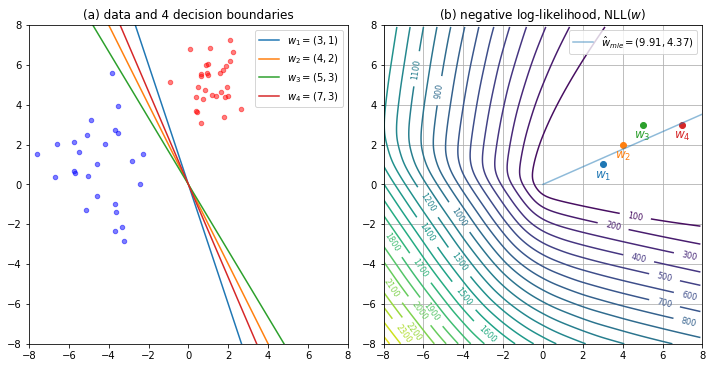

In [4]:
lim = (-8, 8)
xs = np.arange(*lim, 0.1)
xx, yy = np.meshgrid(xs, xs)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

# (a) Plotting data

weights = np.array([[3, 1], [4, 2], [5, 3], [7, 3]])
for i, w in enumerate(weights):
    # decision boundary = -w[0] / w[1] = -b / w
    ax1.axline(
        xy1=(0, 0), slope=-w[0] / w[1], color=f'C{i}',
        label=f'$w_{i+1}=({w[0]},{w[1]})$'
    )
ax1.scatter(*X[y == 1].T, s=20, marker='o', color='red', alpha=0.5)
ax1.scatter(*X[y == 0].T, s=20, marker='o', color='blue', alpha=0.5)

ax1.set_xlim(lim)
ax1.set_ylim(lim)
ax1.set_aspect('equal')
ax1.set_title('(a) data and 4 decision boundaries')
ax1.legend()

# (b) Plotting negative log-likelihood

W = np.stack((xx.ravel(), yy.ravel()), axis=1)
neg_log_likelihood = nll(W, X, y)

cs = ax2.contour(xx, yy, neg_log_likelihood.reshape(xx.shape), levels=30)
ax2.clabel(cs, inline=True, fontsize=8)
for i, w in enumerate(weights):
    ax2.plot(w[0], w[1], marker='o', color=f'C{i}')
    ax2.text(w[0], w[1]-0.25, f'$w_{i+1}$', color=f'C{i}', ha='center', va='top', fontsize=12)
ax2.plot(
    (0, w_mle[0]), (0, w_mle[1]), alpha=0.5,
    label=f'$\hat w_{{mle}}=({w_mle[0]:.2f}, {w_mle[1]:.2f})$'
)
ax2.set_xlim(lim)
ax2.set_ylim(lim)
ax2.set_aspect('equal')
ax2.set_title('(b) negative log-likelihood, $\operatorname{NLL}(w)$')
ax2.grid(True)
ax2.legend()

fig.tight_layout()


#### Unnormalized negative log posterior

$$
\begin{align*}
\operatorname{PNLL}(w) &= \operatorname{NLL}(w) + \lambda\|w\|_2^2 \\
\nabla_w\operatorname{PNLL}(w) &= \nabla_w\operatorname{NLL}(w) + 2\lambda w \\
\nabla_w^2\operatorname{PNLL}(w) &= \nabla_w^2\operatorname{NLL}(w) + 2\lambda I
\end{align*}
$$
where the prior is a Gaussian, $p(w)=\mathcal{N}(w|0,\sigma^2I)$, where $\lambda=\frac{1}{2\sigma^2}$.

In [5]:
# Find the MAP estimate of PNLL(w)
def pnll(w, X, y, λ):
    return nll(w, X, y) + λ * np.sum(w * w, axis=-1) 

def jac_pnll(w, X, y, λ):
    return jac_nll(w, X, y) + 2 * λ * w

def hess_pnll(w, X, y, λ):
    return hess_nll(w, X, y) + 2 * λ * np.identity(D)

var = 10 ** 2
λ = 1 / (2 * var)
ww = minimize(pnll, np.zeros(D), args=(X, y, λ), method='Newton-CG', jac=jac_pnll, hess=hess_pnll)
w_map = ww['x']
H_map = hess_pnll(w_map, X, y, λ)
ww

     fun: 0.09925146564833699
     jac: array([-1.16070116e-07, -6.72815523e-07])
 message: 'Optimization terminated successfully.'
    nfev: 13
    nhev: 12
     nit: 12
    njev: 13
  status: 0
 success: True
       x: array([3.49755353, 1.50791866])

#### Figure 10.13: (c) Unnormalized negative log posterior (assuming vague spherical prior, $\mathcal{N}(w|0,10^2I)$). (d) Laplace approximation to negative log posterior.

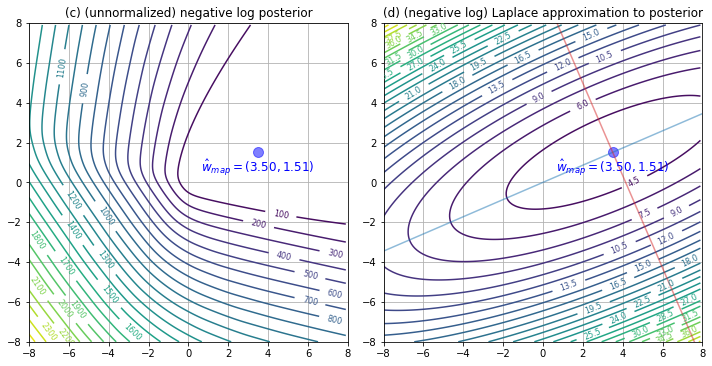

In [6]:
from scipy.stats import multivariate_normal
neg_log_posterior = pnll(W, X, y, λ)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

# (c) Plotting the (unnormalised) negative log posterior

cs = ax1.contour(xx, yy, neg_log_posterior.reshape(xx.shape), levels=30)
ax1.clabel(cs, inline=True, fontsize=8)

ax1.plot(
    w_map[0], w_map[1], marker='o', markersize=10, color='blue', alpha=0.5
)
ax1.text(
    w_map[0], w_map[1]-0.25, f'$\hat w_{{map}}=({w_map[0]:.2f}, {w_map[1]:.2f})$',
    color='blue', ha='center', va='top', fontsize=12
)
ax1.set_xlim(lim)
ax1.set_ylim(lim)
ax1.set_aspect('equal')
ax1.set_title('(c) (unnormalized) negative log posterior')
ax1.grid(True)

# (d) Plotting the negative log Laplace approximation to posterior

neg_log_laplace_posterior = -np.log(
    multivariate_normal.pdf(W, mean=w_map, cov=np.linalg.inv(H_map))
)

cs = ax2.contour(xx, yy, neg_log_laplace_posterior.reshape(xx.shape), levels=30)
ax2.clabel(cs, inline=True, fontsize=8)
ax2.plot(
    w_map[0], w_map[1], marker='o', markersize=10, color='blue', alpha=0.5
)
ax2.text(
    w_map[0], w_map[1]-0.25, f'$\hat w_{{map}}=({w_map[0]:.2f}, {w_map[1]:.2f})$',
    color='blue', ha='center', va='top', fontsize=12
)
ax2.axline(xy1=(0, 0), xy2=w_map, color='tab:blue', alpha=0.5)
ax2.axline(xy1=w_map, slope=-w_map[0] / w_map[1], color='tab:red', alpha=0.5)
ax2.set_xlim(lim)
ax2.set_ylim(lim)
ax2.set_aspect('equal')
ax2.set_title('(d) (negative log) Laplace approximation to posterior')
ax2.grid(True)

fig.tight_layout()

#### Figure 10.14: Posterior predictive distribution for a logistic regression model in 2d. (a) Contours of $p(y=1|x;\hat w_\text{map})=\sigma(\hat w_\text{map}^Tx)$. (b) Samples from the posterior predictive distribution.

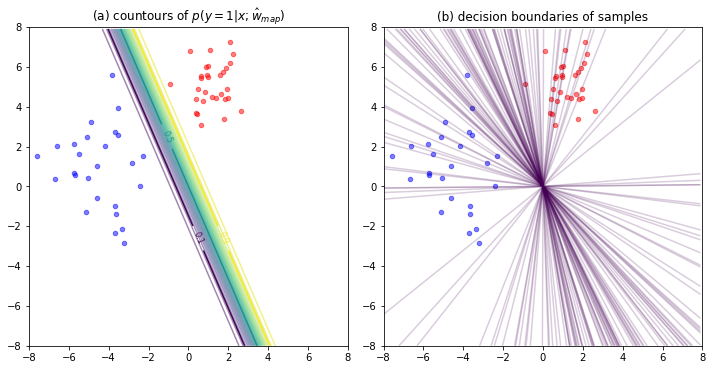

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

# (a) Plotting the predictive distribution for logistic regression

pred_dist = expit(np.dot(W, w_map))
ax1.contour(xx, yy, pred_dist.reshape(xx.shape), levels=30, alpha=0.5)
cs = ax1.contour(xx, yy, pred_dist.reshape(xx.shape), levels=[0.1, 0.5, 0.9])
ax1.clabel(cs, inline=True, fontsize=8)

ax1.scatter(*X[y == 1].T, s=20, marker='o', color='red', alpha=0.5)
ax1.scatter(*X[y == 0].T, s=20, marker='o', color='blue', alpha=0.5)
ax1.set_xlim(lim)
ax1.set_ylim(lim)
ax1.set_aspect('equal')
ax1.set_title('(a) countours of $p(y=1|x;\hat w_{map})$')

# (b) Decision boundary for sampled w

pred_mean = np.zeros_like(pred_dist)
s = 100
for _ in range(s):
    w_sample = rng.multivariate_normal(mean=w_map, cov=np.linalg.inv(H_map))
    pred_dist = expit(np.dot(W, w_sample))
    pred_mean += pred_dist
    ax2.contour(xx, yy, pred_dist.reshape(xx.shape), levels=[0.5], alpha=0.2)
pred_mean /= s

ax2.scatter(*X[y == 1].T, s=20, marker='o', color='red', alpha=0.5)
ax2.scatter(*X[y == 0].T, s=20, marker='o', color='blue', alpha=0.5)
ax2.set_xlim(lim)
ax2.set_ylim(lim)
ax2.set_aspect('equal')
ax2.set_title('(b) decision boundaries of samples')

fig.tight_layout()

#### Figure 10.14: (c) Averaging over these samples. (d) Moderated output (probit approximation).

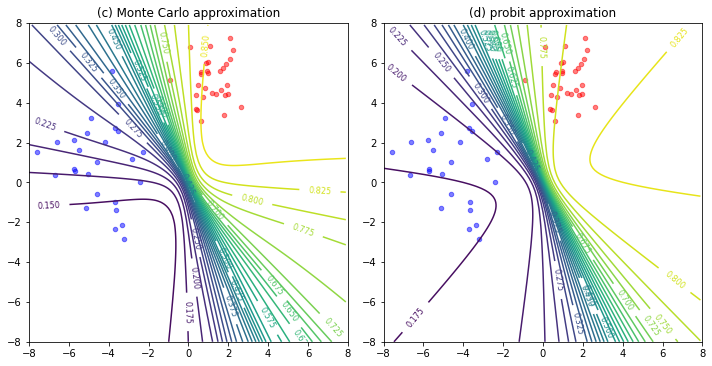

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

# (c) Monte Carlo approximation

cs = ax1.contour(xx, yy, pred_mean.reshape(xx.shape), levels=30)
ax1.clabel(cs, inline=True, fontsize=8)
ax1.scatter(*X[y == 1].T, s=20, marker='o', color='red', alpha=0.5)
ax1.scatter(*X[y == 0].T, s=20, marker='o', color='blue', alpha=0.5)
ax1.set_xlim(lim)
ax1.set_ylim(lim)
ax1.set_aspect('equal')
ax1.set_title('(c) Monte Carlo approximation')

# (d) Probit approximation

def probit_approximation(X, w, H):
    H_inv_ = np.linalg.inv(H)
    sig2_a = np.sum(X * np.dot(H_inv_, X.T).T, axis=1)
    kappa_sig2_a = 1 / np.sqrt(1 + 0.125 * np.pi * sig2_a)
    return expit(w @ X.T * kappa_sig2_a)

cs = ax2.contour(xx, yy, probit_approximation(W, w_map, H_map).reshape(xx.shape), levels=30)
ax2.clabel(cs, inline=True, fontsize=8)

ax2.scatter(*X[y == 1].T, s=20, marker='o', color='red', alpha=0.5)
ax2.scatter(*X[y == 0].T, s=20, marker='o', color='blue', alpha=0.5)
ax2.set_xlim(lim)
ax2.set_ylim(lim)
ax2.set_aspect('equal')
ax2.set_title('(d) probit approximation')

fig.tight_layout()